This Notebooks contain the lastest version of the full model of optimisation

In [2]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path().resolve().parents[0]
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.cm as cm
from matplotlib.lines import Line2D
import logging
logging.getLogger("aequilibrae").setLevel(logging.CRITICAL)

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix


from utils_traffic import *
import logging
logging.getLogger("aequilibrae").setLevel(logging.CRITICAL)

from pypalettes import load_palette
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
###### preprocessing functions
def set_capacity_cars(edges_df, capacity_per_lane=100, lanes_col='lanes'):
    edges_df['capacity_cars'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def set_capacity_bikes(edges_df, capacity_per_lane=200, lanes_col='lanes'):
    edges_df['capacity_bikes'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def time_estimation_cars(edges_df):
    travel_time = []
    for _, edge in edges_df.iterrows():
        travel_time.append((edge['length']/1000)/(edge['speed']*0.5))
    edges_df['travel_time_cars'] = travel_time
    return edges_df

def free_flow_time (edges_df, mode):
    name_col = 'free_flow_time_' + mode
    edges_df[name_col] = edges_df['length']/ (edges_df['speed_'+ mode])
    return edges_df

def simple_bi(edges_df, coef = 1):
    length_bi = []
    for _, edge in edges_df.iterrows():
        if edge['type_bike'] == 'bike_lane':
            length_bi.append(edge['length']*0.9*coef)
        elif edge['type_bike'] == 'bike_path':
            length_bi.append(edge['length']*0.5*coef)
        else:
            length_bi.append(edge['length']*2*coef)
    edges_df['length_bi'] = length_bi
    return edges_df

def estimate_traffic (edges_df):
    traffic = []
    for _, edge in edges_df.iterrows():
        if edge['type_car']=='primary':
            traffic.append(500)
        elif edge['type_car']=='secondary':
            traffic.append(250)
        else :
            traffic.append(100)
    edges_df['traffic'] = traffic
    return edges_df

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 3000:
        return 1.7
    elif traffic < 100:
        return 0.9
    else :
        return 1.3
    

def simple_bi_2(edges_df, traffic_col='traffic'):
    length_bi = []
    for _, edge in edges_df.iterrows():
        perceived_l = 0
        perceived_l += pl_type_bike(edge['type_bike'])
        perceived_l += pl_slope(edge['slope'])
        perceived_l += pl_green(edge['green_blue_coverage'])
        perceived_l += pl_traffic(edge[traffic_col])
        length_bi.append(perceived_l/4)
    edges_df['length_bi'] = length_bi*edges_df['length']
    edges_df['length_bi'] = edges_df['length_bi'].astype(np.float64)
    return edges_df

def simple_bi_3 (edge_df, traffic_car_col='flow_car', coef=1):
    liste_length_bi = []
    for _, edge in edge_df.iterrows():
        if edge['type_bike'] == 'bike_path':
            perceived_l = 0.5
        else :
            if edge[traffic_car_col]<800:
                perceived_l = 0.8
            elif edge[traffic_car_col]>=800 and edge[traffic_car_col]<1000:
                perceived_l = 1
            elif edge[traffic_car_col]>=1000 and edge[traffic_car_col]<3000:
                perceived_l = 1.2
            else:
                perceived_l = 1.7
        liste_length_bi.append(perceived_l*coef)
    edge_df['length_bi'] = edge_df['length']*liste_length_bi
    edge_df['length_bi'] = edge_df['length_bi'].astype(np.float64)
    return edge_df

def reset_flows(edges_df, flow_key='flow'):
    edges_df[flow_key] = 0
    return edges_df

def change_type_bike(edges_df, a_node, b_node, new_type):
    edges_df = edges_df.copy()
    idx = edges_df[(edges_df['a_node']==a_node) & (edges_df['b_node']==b_node)].index
    edges_df.loc[idx, 'type_bike'] = new_type
    return edges_df

def lock_infra(edges_df, a_node, b_node):
    edges_df = edges_df.copy()
    idx = edges_df[(edges_df['a_node']==a_node) & (edges_df['b_node']==b_node)].index
    edges_df.loc[idx, 'lock_bike_infra'] = True
    return edges_df

def calculate_length(node_df, edge_df):
    lengths = []
    for edge in edge_df.itertuples():
        a_node = node_df.loc[node_df['node'] == edge.a_node]
        b_node = node_df.loc[node_df['node'] == edge.b_node]
        length = np.sqrt((a_node['x'].values[0] - b_node['x'].values[0])**2 + (a_node['y'].values[0] - b_node['y'].values[0])**2)
        lengths.append(length)
    return edge_df.assign(length=lengths)

#### plotting functions
def _create_offset_polygon(coords, width):
    """Create polygon offset to right of line."""
    if len(coords) < 2:
        return None

    right_pts, left_pts = [], []
    for i, (cx, cy) in enumerate(coords):
        if i == 0:
            dx, dy = coords[1][0] - coords[0][0], coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:
            dx, dy = coords[-1][0] - coords[-2][0], coords[-1][1] - coords[-2][1]
        else:
            dx = (coords[i + 1][0] - coords[i - 1][0]) / 2
            dy = (coords[i + 1][1] - coords[i - 1][1]) / 2

        length = np.sqrt(dx ** 2 + dy ** 2)
        if length > 0:
            dx, dy = dx / length, dy / length

        perp_x, perp_y = dy, -dx
        right_pts.append((cx + perp_x * width, cy + perp_y * width))
        left_pts.append((cx, cy))

    try:
        polygon = Polygon(right_pts + left_pts[::-1])
        return polygon if polygon.is_valid else polygon.buffer(0)
    except:
        return None

def plot_network(edges_df, nodes_df, ax=None, figsize=(10,10), node_x_col='x', node_y_col='y', 
                 width_col=None, base_width=0.1, width_scale=2.1, node_id_col='node', color_col_num=None, color_col_str=None, dict_colors_str=None,
                 vmin=None, vmax=None, a_node_col='a_node', b_node_col='b_node', show_nodes=True,
                 node_size=100, cmap='viridis', colorbar_label=None, title=None, node_label=False, legend=False, edges_label_col=None, cbar_on=True):
    
    edges_df = edges_df.reset_index(drop=True)

    if dict_colors_str is not None:
        dict_colors = dict_colors_str
    else:
        dict_colors = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF', 'none':'black'}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x_range = nodes_df[node_x_col].max() - nodes_df[node_x_col].min()
    y_range = nodes_df[node_y_col].max() - nodes_df[node_y_col].min()
    scale = min(x_range, y_range) / 100

    scaled_base = scale * base_width
    scaled_scale = scale * width_scale * 0.0001

    node_coords = {r[node_id_col]: (r[node_x_col], r[node_y_col])
                   for _, r in nodes_df.iterrows()}
    
    if width_col is not None:
        width_vals = edges_df[width_col].fillna(0).values if width_col in edges_df.columns else np.ones(len(edges_df))
        if color_col_num is None:
            color_col_num = width_col
    
    if color_col_num in edges_df.columns:
        color_vals = edges_df[color_col_num].fillna(0).values

        # Use provided vmin/vmax or compute from data
        if vmin is None:
            vmin = np.nanmin(color_vals)
        if vmax is None:
            vmax = np.nanmax(color_vals)
        if vmin == vmax:
            vmax = vmin + 1

        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        use_cmap = True
    else:
        use_cmap = False
    
    if color_col_str in edges_df.columns:
        color_vals = []
        for edge in edges_df.itertuples():
            color_vals.append(dict_colors.get(getattr(edge, color_col_str), 'black'))
        use_cmap = False
    
    if color_col_num is None and color_col_str is None:
        color_vals = ['black'] * len(edges_df)
        use_cmap = False
    # Use enumerate to get integer index for numpy array access
    for idx, edge in edges_df.iterrows():
        a_coords = node_coords.get(edge[a_node_col])
        b_coords = node_coords.get(edge[b_node_col])
        if a_coords is None or b_coords is None:
            continue

        # Use idx (which is now 0..N-1 due to reset_index) to access arrays
        if width_col is not None:
            width = scaled_base + width_vals[idx] * scaled_scale
        else:
            width = scaled_base
        polygon = _create_offset_polygon([a_coords, b_coords], width)

        if polygon:
            color = sm.to_rgba(color_vals[idx]) if use_cmap else color_vals[idx]
            x, y = polygon.exterior.xy
            ax.fill(x, y, color=color, alpha=1, edgecolor='black', linewidth=0.1)

    if show_nodes:
        ax.scatter(nodes_df[node_x_col], nodes_df[node_y_col], s=node_size, c='white', zorder=5, edgecolors='black')
        if node_label :
            for _, row in nodes_df.iterrows():
                ax.text(row[node_x_col], row[node_y_col], str(int(row[node_id_col])), fontsize=8,
                        ha='center', va='center', zorder=6)

    if legend and color_col_str is not None:
        legend_elements = []
        for key, color in dict_colors.items():
            legend_elements.append(Line2D([0], [0], color=color, lw=4, label=key))
        ax.legend(handles=legend_elements, loc='lower right')
        
    if use_cmap:
        # Determine colorbar label
        if colorbar_label is None:
            colorbar_label = color_col_num.replace('_', ' ').title()
        if cbar_on:
            cbar = plt.colorbar(sm, ax=ax, label=colorbar_label, shrink=0.8)

    if edges_label_col is not None and edges_label_col in edges_df.columns:
        for _, edge in edges_df.iterrows():
            a_coords = node_coords.get(edge[a_node_col])
            b_coords = node_coords.get(edge[b_node_col])
            if a_coords is None or b_coords is None:
                continue
            mid_x = (a_coords[0] + b_coords[0]) / 2
            mid_y = (a_coords[1] + b_coords[1]) / 2
            if a_coords[0] == b_coords[0]:  # horizontal line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white', rotation='vertical')
            else:  # vertical line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white')
            
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title or f'Network (width by {width_col})')
    plt.tight_layout()
    
    if ax is None:
        return fig, ax

def plot_vc_histogram(results_df, capacity_col='capacity', bins=5):
    """Plot V/C ratio histogram."""
    ratios = results_df['flow'] / results_df[capacity_col].replace(0, np.inf)
    ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()

    if len(ratios) == 0:
        print("No valid V/C ratios to plot")
        return None, None

    counts, edges = np.histogram(ratios, bins=bins)
    cmap = mcolors.LinearSegmentedColormap.from_list('', ['#2ecc71', '#f1c40f', '#e74c3c'])
    colors = [cmap(i / max(1, bins - 1)) for i in range(bins)]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(edges[:-1], counts, width=edges[1] - edges[0], color=colors, edgecolor='black', alpha=0.8, align='edge')

    for pos, cnt in zip(edges[:-1], counts):
        if cnt > 0:
            ax.text(pos + (edges[1] - edges[0]) / 2, cnt, str(int(cnt)), ha='center', va='bottom', fontweight='bold')

    ax.set_xlabel('Volume/Capacity Ratio')
    ax.set_ylabel('Number of Links')
    ax.set_title('Link Congestion Distribution')
    ax.grid(axis='y', alpha=0.6, linestyle='--')
    plt.tight_layout()

    return fig, ax

def plot_od_matrix(od_matrix, edges_df, nodes_df, ax=None, figsize=(10,10), cmap='viridis', title='OD Matrix', label=True, color='red', vmax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    plot_network(edges_df, nodes_df, ax=ax, show_nodes=True, node_label=True, node_size=300, title=title)
    od_matrix_plot = od_matrix.copy()[od_matrix['demand']>0]
    if vmax is None:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / od_matrix_plot['demand'].max() * 5
    else:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / vmax * 5
    

    for i, row in od_matrix_plot.iterrows():
        x0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'x'].values[0]
        y0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'y'].values[0]
        x1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'x'].values[0]
        y1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'y'].values[0]

        ax.annotate(
        "",
        xy=(x1, y1),      # destination
        xytext=(x0, y0),  # origine
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            lw=row['linewidth']
        ),
        zorder=3
        )
        if label :
            xm = (x0 + x1-100) / 2
            ym = (y0 + y1+100) / 2
            dx = x1 - x0
            dy = y1 - y0

            # Vecteur perpendiculaire unitaire
            nx = -dy
            ny = dx
            norm = np.sqrt(nx**2 + ny**2)
            nx /= norm
            ny /= norm

            # Distance du décalage (à ajuster si besoin)
            offset = 0.015 * np.hypot(dx, dy)

            # Position finale du texte
            xt = xm + nx * offset
            yt = ym + ny * offset

            # Texte
            ax.text(
                xt, yt,
                str(int(row['demand'])),
                color='black',
                fontsize=9,
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=4
            )

    
    if ax is None:
        return fig, ax
    
##### eaquilibrae pre processing

def convert_to_eaquilibrae_df(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    return edges_df

def convert_to_eaquilibrae_df_v2(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    edges_df_2 = edges_df.copy()
    edges_df_2.rename(columns={'a_node': 'b_node', 'b_node': 'a_node'}, inplace=True)
    edges_df = pd.concat([edges_df, edges_df_2], ignore_index=True)
    return edges_df, len(edges_df_2)

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

def convert_from_eaquilibrae_df_to_graph(results_stochastic):
    network_with_flows = results_stochastic['network']
    G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2

def convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df):
    network_with_flows = results_stochastic['network']
    print(network_with_flows)
    base_df = network_with_flows[:len_df].copy()
    print(base_df)
    reversed_df = network_with_flows[len_df:].copy()
    print(reversed_df)
    base_df['flow'] = base_df['flow'] + reversed_df['flow'].values
    G_2 = nx.from_pandas_edgelist(
    base_df,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2



#####models

def _build_demand_matrix(od_gdf, name='matrix'):
    """Convert OD GeoDataFrame to AequilibraeMatrix."""
    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    od_matrix = np.zeros((zones, zones))

    for _, row in od_gdf.iterrows():
        od_matrix[int(row['origin']) - 1, int(row['destination']) - 1] = row['demand']

    demand = AequilibraeMatrix()
    demand.create_empty(zones=zones, matrix_names=[name], memory_only=True)
    demand.matrix[name][:, :] = od_matrix
    demand.index[:] = np.arange(1, zones + 1).astype(int)
    demand.computational_view([name])

    return demand

def _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field='capacity'):
    """Build graph for stochastic assignment."""
    network_df = network_df.copy()
    network_df['direction'] = 1
    network_df.index = list(range(len(network_df)))
    network_df["link_id"] = network_df.reset_index().index + 1
    network_df = network_df.astype({"a_node": "int64", "b_node": "int64", "direction": "int64", "link_id": "int64"})

    g = Graph()
    g.cost = network_df[cost_field].values
    g.capacity = network_df[capacity_field].values
    g.free_flow = network_df[time_field].values

    g.network = network_df
    g.network_ok = True
    g.status = 'OK'
    g.prepare_graph(np.arange(1, zones + 1).astype(int))
    g.set_graph(cost_field)
    g.cost = np.array(g.cost, copy=True)
    g.set_blocked_centroid_flows(False)
    g.network["id"] = g.network.link_id

    return g

def _empty_result(results_df, n):
    """Return empty result dict for failed assignments."""
    results_df['flow'] = np.zeros(n)
    results_df['time'] = np.zeros(n)
    return {
        'network': results_df,
        'total_travel_time': np.inf,
        'computation_time': 0,
        'rgap': np.inf,
        'flow': np.zeros(n),
        'time': np.zeros(n),
        'convergence': None
    }

def ta_due(edges_gdf, od_gdf, algorithm='bfw', max_iter=500, tolerance=1e-4,
           time_field='free_flow_time', cost_field='free_flow_time',capacity_field='capacity_cars'):
    """
    Deterministic User Equilibrium (DUE) traffic assignment.
    """
    network_df = edges_gdf.copy()
    if 'geometry' in network_df.columns:
        network_df = pd.DataFrame(network_df.drop(columns=['geometry']))

    network_df['alpha'] = network_df['alpha'].fillna(0.15)
    network_df['beta'] = network_df['beta'].fillna(4.0)
    network_df[capacity_field] = network_df[capacity_field].fillna(99999)
    network_df[time_field] = network_df[time_field].fillna(100.00)

    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    demand = _build_demand_matrix(od_gdf)

    network_df = network_df.sort_values(by=['a_node', 'b_node']).reset_index(drop=True)
    network_df['direction'] = 1
    network_df.index = list(range(len(network_df)))
    network_df["link_id"] = network_df.reset_index().index +1
    network_df = network_df.astype({"a_node": "int64", "b_node": "int64", "direction": "int64", "link_id": "int64"})

    g = Graph()
    g.cost = network_df[cost_field].values
    g.capacity = network_df[capacity_field].values
    g.free_flow = network_df[time_field].values
    g.network = network_df
    g.network_ok = True
    g.status = 'OK'
    g.prepare_graph(np.arange(1, zones + 1).astype(int))
    g.set_graph(cost_field)
    g.cost = np.array(g.cost, copy=True)
    g.set_blocked_centroid_flows(False)
    g.network["id"] = g.network.link_id

    traffic_class = TrafficClass('car', g, demand)
    assignment = TrafficAssignment()
    assignment.set_classes([traffic_class])
    assignment.set_vdf('BPR')
    assignment.set_vdf_parameters({"alpha": "alpha", "beta": "beta"})
    assignment.set_capacity_field(capacity_field)
    assignment.set_time_field(cost_field)
    assignment.set_algorithm(algorithm)
    assignment.max_iter = max_iter
    assignment.rgap_target = tolerance

    results_df = network_df.copy()
    start_time = time.time()

    try:
        assignment.execute()
        computation_time = time.time() - start_time

        results = assignment.results()
        flows = results['matrix_ab'].values
        times = results['Congested_Time_AB'].values
        total_travel_time = np.sum(flows * times)
        rgap_list = list(assignment.report()['rgap'])
        rgap = rgap_list[-1] if rgap_list else np.inf

        results_df['flow'] = flows
        results_df['time'] = times
        results_df['ratio'] = flows / results_df[capacity_field].replace(0, np.inf)
        convergence = pd.DataFrame(assignment.assignment.convergence_report)

        print(f"DUE completed in {computation_time:.2f}s | RGAP: {rgap:.6f} | TTT: {total_travel_time:.0f}")

        return {
            'network': results_df,
            'total_travel_time': total_travel_time,
            'computation_time': computation_time,
            'rgap': rgap,
            'flow': flows,
            'time': times,
            'convergence': convergence
        }

    except Exception as e:
        print(f"Error in DUE assignment: {e}")
        import traceback
        traceback.print_exc()
        return _empty_result(results_df, len(network_df))
    
def ta_stochastic(edges_gdf, od_gdf, mode='car',
                  time_field='free_flow_time', cost_field='free_flow_time', capacity_field='capacity',
                  algorithm='bfsle', max_routes=5, max_depth=100, max_misses=100,
                  beta=1.0, cutoff_prob=0.0, penalty=1.0, seed=0, cores=1):
    """
    Stochastic (uncongested) traffic assignment using Route Choice.
    """
    network_df = edges_gdf.copy()
    if 'geometry' in network_df.columns:
        network_df = pd.DataFrame(network_df.drop(columns=['geometry']))

    network_df[capacity_field] = network_df[capacity_field].fillna(99999)
    network_df[time_field] = network_df[time_field].fillna(100.01)
    if cost_field != time_field:
        network_df[cost_field] = network_df[cost_field].fillna(100.01)

    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    demand = _build_demand_matrix(od_gdf)

    network_df = network_df.sort_values(by=['a_node', 'b_node']).reset_index(drop=True)
    graph = _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field=capacity_field)

    route_choice = RouteChoice(graph)
    route_choice.set_cores(cores)
    route_choice.set_choice_set_generation(
        algorithm=algorithm,
        max_routes=max_routes,
        max_depth=max_depth,
        max_misses=max_misses,
        beta=beta,
        cutoff_prob=cutoff_prob,
        penalty=penalty,
        seed=seed
    )
    route_choice.add_demand(demand)
    route_choice.prepare(nodes=None)

    results_df = network_df.copy()
    start_time = time.time()

    try:
        route_choice.execute(perform_assignment=True)
        computation_time = time.time() - start_time

        load_results = route_choice.get_load_results()
        flows = load_results['matrix_ab'].values
        times = results_df[time_field].values
        costs = results_df[cost_field].values

        total_travel_time = np.sum(flows * times)
        total_travel_cost = np.sum(flows * costs)

        results_df['flow'] = flows
        results_df['time'] = times
        results_df['cost'] = costs

        #print(f"Stochastic ({mode}) completed in {computation_time:.2f}s | TTT: {total_travel_time:.0f}")

        return {
            'network': results_df,
            'total_travel_time': total_travel_time,
            'total_travel_cost': total_travel_cost,
            'computation_time': computation_time,
            'flow': flows,
            'time': times,
            'cost': costs
        }

    except Exception as e:
        print(f"Error in stochastic assignment: {e}")
        import traceback
        traceback.print_exc()
        return _empty_result(results_df, len(network_df))


def model_eaquilibrae_stochastic(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df = convert_to_eaquilibrae_df(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph(results_stochastic)
    return G_2

def model_eaquilibrae_stochastic_v2(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df, len_df = convert_to_eaquilibrae_df_v2(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df)
    return G_2

def calculate_congested_time(edges_df, free_flow_time_name="free_flow_time", congested_time_name="congested_time", flow_name="flow", capacity_name="capacity", alpha=0.15, beta=4):
    """Calculate congested travel time using BPR function.
    𝑇=𝑇0(1+α(𝑉/𝐶)^β)
    where:
    - 𝑇 is the congested travel time
    - 𝑇0 is the free-flow travel time
    - 𝑉 is the volume (flow)
    - 𝐶 is the capacity
    - α and β are parameters
    """
    edges_df[congested_time_name]=edges_df[free_flow_time_name]*(1+alpha*(edges_df[flow_name]/edges_df[capacity_name])**beta)

# Loop 1

In [5]:
#import
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

edge_df = set_capacity_bikes(edge_df, capacity_per_lane=200) #manual assigment of slope, gb coverage, lane capacity
edge_df = set_capacity_cars(edge_df, capacity_per_lane=2000)

edge_df = free_flow_time(edge_df, 'car')
edge_df = free_flow_time(edge_df, 'bike')
edge_df["travel_time_car"] = edge_df['free_flow_time_car']
edge_df["travel_time_bike"] = edge_df['free_flow_time_bike']
edge_df['length'] = edge_df['length'].apply(lambda x: np.float64(x))
edge_df['slope']=1 
edge_df['green_blue_coverage']=0.7
edge_df['alpha']=0.15
edge_df['beta']=4.0
edge_df['capacity_cars']=4000
edge_df_modif = edge_df.copy()
for edge in edge_df.itertuples():
    edge_df_modif = change_type_bike(edge_df_modif, edge.a_node, edge.b_node, 'bike_path')

#OD matrix
# Base OD matrix
np.random.seed(69)
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
for i in liste_i:
    for j in liste_i:
        if i != j:
            od_matrix.loc[i,j] = np.random.randint(30,1000)
modal_share = {'bike': 0.35, 'car': 0.65}
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']
od_bike = convert_to_eaquilibrae_od_matrix(od_bike)
od_car = convert_to_eaquilibrae_od_matrix(od_car)

In [6]:
edge_df_tri=edge_df_modif.copy().reset_index(drop=True)
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
# counter
i = 0
limit = 100

# parameters for stochastic assignment
beta = 1
cutoff_prob = 0.0

# parameters for mode choice
beta_time = -0.01
ASC_car = 0
ASC_bike = -2.5
mu_mode = 1.0
loop_count = 10
# other parameters
speed_bike = 17
speed_car = 15
speed_bike = speed_bike / 3.6 # in m/s
speed_car = speed_car / 3.6 # in m/s

edge_df_tri["speed_car"] = speed_car
edge_df_tri["speed_bike"] = speed_bike

edge_df_tri = free_flow_time(edge_df_tri, 'car')
edge_df_tri = free_flow_time(edge_df_tri, 'bike')

edge_df_tri["travel_time_car"] = edge_df_tri['free_flow_time_car']
edge_df_tri["travel_time_bike"] = edge_df_tri['free_flow_time_bike']
nbr_bike_lanes = edge_df_modif['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_modif['type_bike'].isnull().sum()
results_df = pd.DataFrame({'iteration': [0],
                        'nbr_bike_lanes': nbr_bike_lanes,
                        'nbr_none_bike_lanes': nbr_none_bike_lanes,
                        'modal_share_car': [np.nan],
                        'modal_share_bike': [np.nan]})

while nbr_bike_lanes > 0 and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    print("➡️ Running mode choice...")
    
    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # mode choice adjustment
    j = 0
    while j < loop_count:
        j += 1
        #create skim matrices
        skim_car = np.zeros((16,16))
        skim_bike = np.zeros((16,16))

        # Car skimming using current edge travel times
        G_car = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_car.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_car'])

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_car[origin-1, destination-1] = nx.shortest_path_length(G_car, source=origin, target=destination, weight='time')
                    except:
                        skim_car[origin-1, destination-1] = 9999

        # Bike skimming using current edge travel times
        G_bike = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_bike.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_bike'])
        
        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_bike[origin-1, destination-1] = nx.shortest_path_length(G_bike, source=origin, target=destination, weight='time')
                    except:
                        skim_bike[origin-1, destination-1] = 9999

        # Calculate utilities and mode share for each OD pair
        od_mode_shares_skim = np.zeros((16,16,2)) # 3rd dimension: 0 for car, 1 for bike
        total_car_skim = 0
        total_bike_skim = 0

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination and od_matrix.loc[origin, destination] > 0:
                    # Utilities
                    V_car = ASC_car + beta_time * skim_car[origin-1, destination-1]
                    V_bike = ASC_bike + beta_time * skim_bike[origin-1, destination-1] # TO MODIFY FOR AN OTHER UTILITY FUNCTION

                    # Probabilities using logit model
                    exp_car = np.exp(mu_mode * V_car)
                    exp_bike = np.exp(mu_mode * V_bike)
                    P_car = exp_car / (exp_car + exp_bike)
                    P_bike = exp_bike / (exp_car + exp_bike)

                    od_mode_shares_skim[origin-1, destination-1, 0] = P_car
                    od_mode_shares_skim[origin-1, destination-1, 1] = P_bike

                    # Accumulate total mode shares
                    total_car_skim += od_matrix.loc[origin, destination] * P_car
                    total_bike_skim += od_matrix.loc[origin, destination] * P_bike
        
        # Update OD matrices based on mode shares
        updated_od_car = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
        updated_od_bike = pd.DataFrame(0, index=range(1,17), columns=range(1,17))

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    total_od = od_matrix.loc[origin, destination]
                    P_car = od_mode_shares_skim[origin-1, destination-1, 0]
                    P_bike = od_mode_shares_skim[origin-1, destination-1, 1]
                    updated_od_car.loc[origin, destination] = total_od * P_car
                    updated_od_bike.loc[origin, destination] = total_od * P_bike
        
        updated_od_car = convert_to_eaquilibrae_od_matrix(updated_od_car)
        updated_od_bike = convert_to_eaquilibrae_od_matrix(updated_od_bike)

        #run traffic assignments with updated OD matrices
        car_results_mode_choice = ta_stochastic(
                                    edge_df_tri,
                                    updated_od_car,
                                    mode='cars',
                                    time_field='travel_time_car',
                                    cost_field='length',
                                    algorithm='bfsle',
                                    max_routes=1,
                                    capacity_field='capacity_cars'
                                    )['network']
        
        edge_df_tri['flow_car'] = 0
        for idx, row in car_results_mode_choice.iterrows():
            if idx < len(edge_df_tri):
                edge_df_tri.loc[idx, 'flow_car'] = row['flow']
        
        edge_df_tri = simple_bi_3(edge_df_tri, traffic_car_col='flow_car')
        bike_results_mode_choice = ta_stochastic(
                                    edge_df_tri, 
                                    updated_od_bike, 
                                    mode='bikes',
                                    time_field='travel_time_bike', 
                                    cost_field='length', ### LENGTH OR LENGTH_BI?
                                    algorithm='bfsle', 
                                    max_routes=3,
                                    capacity_field='capacity_bikes',
                                    beta=beta,
                                    cutoff_prob=cutoff_prob
                                    )['network']
        
        edge_df_tri['flow_bike'] = 0
        for idx, row in bike_results_mode_choice.iterrows():
            if idx < len(edge_df_tri):
                edge_df_tri.loc[idx, 'flow_bike'] = row['flow']
        
        #calculate congested time for cars
        calculate_congested_time(edge_df_tri, flow_name='flow_car',free_flow_time_name='free_flow_time_car', capacity_name="capacity_cars", congested_time_name='travel_time_car', alpha=0.15, beta=4)
        edge_df_tri['travel_time_bike'] = edge_df_tri['length_bi']/speed_bike

    od_bike = updated_od_bike.copy()
    od_car = updated_od_car.copy()
    modal_share_car_iteration = 100*total_car_skim / od_matrix.values.sum()
    modal_share_bike_iteration = 100*total_bike_skim / od_matrix.values.sum()
    results_df.loc[i-1, 'modal_share_car'] = modal_share_car_iteration
    results_df.loc[i-1, 'modal_share_bike'] = modal_share_bike_iteration
    total_demand = od_matrix.values.sum()
    print("✅ Mode choice adjustment done.")
    print(f"\nMode shares with skimming:")
    print(f"  Car: {modal_share_car_iteration:.1f}%")
    print(f"  Bike: {modal_share_bike_iteration:.1f}%")

    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")

    # run car traffic assignment
    cars_results = ta_stochastic(edge_df_tri, od_car, mode='cars',
                  time_field='travel_time_car', cost_field='length',
                  algorithm='bfsle', max_routes=1,
                  capacity_field='capacity_cars')
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car_iteration_1')

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='length_bi', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta,
                                cutoff_prob=cutoff_prob
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("Traffic assignments completed.")

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    indexes_removed = pd.Index([])
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
    indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
    #remove infrastructures from selected edges
    edge_df_tri.loc[indexes_removed, 'type_bike'] = None

    print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
   
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
    results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)



--- Iteration 1 ---
➡️ Running mode choice...
✅ Mode choice adjustment done.

Mode shares with skimming:
  Car: 0.2%
  Bike: 99.8%
➡️ Running traffic assignments...
➡️ Cars assignment...
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 1 - Removing bike lane on edge Index([19], dtype='object') with flow 2956.966823777998

--- Iteration 2 ---
➡️ Running mode choice...
✅ Mode choice adjustment done.

Mode shares with skimming:
  Car: 0.2%
  Bike: 99.8%
➡️ Running traffic assignments...
➡️ Cars assignment...
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 2 - Removing bike lane on edge Index([11], dtype='object') with flow 2704.4617030517525

--- Iteration 3 ---
➡️ Running mode choice...
✅ Mode choice adjustment done.

Mode shares with skimming:
  Car: 0.2%
  Bike: 99.8%
➡️ Running traffic assignments...
➡️ Cars assignment...
✅ Cars assignment done.
➡️ Bikes as

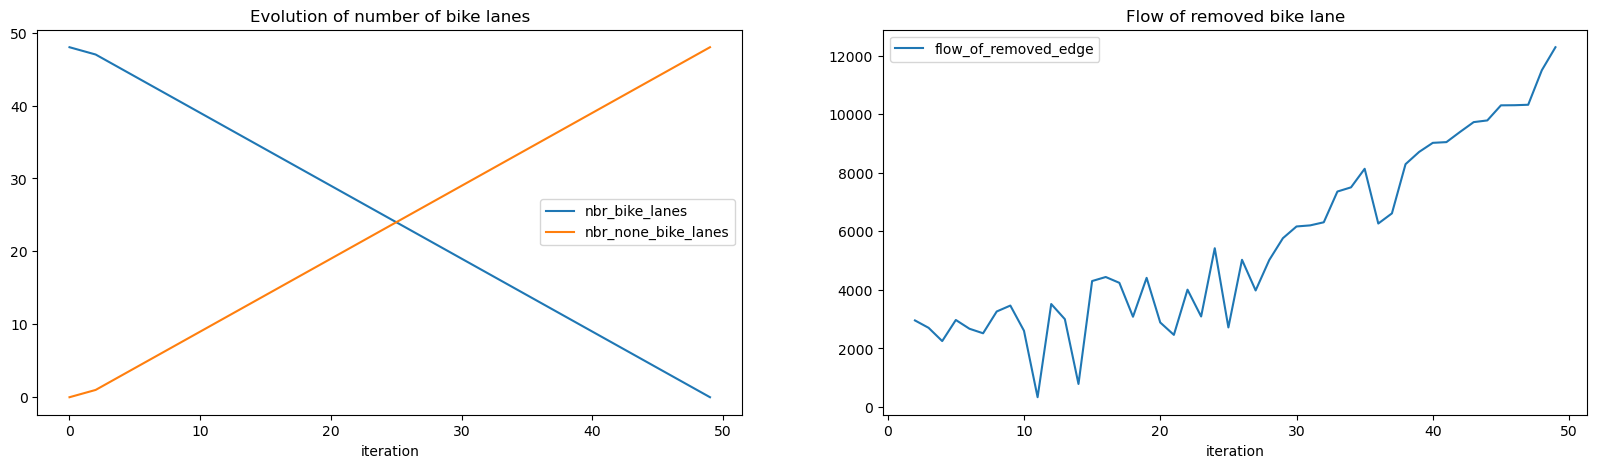

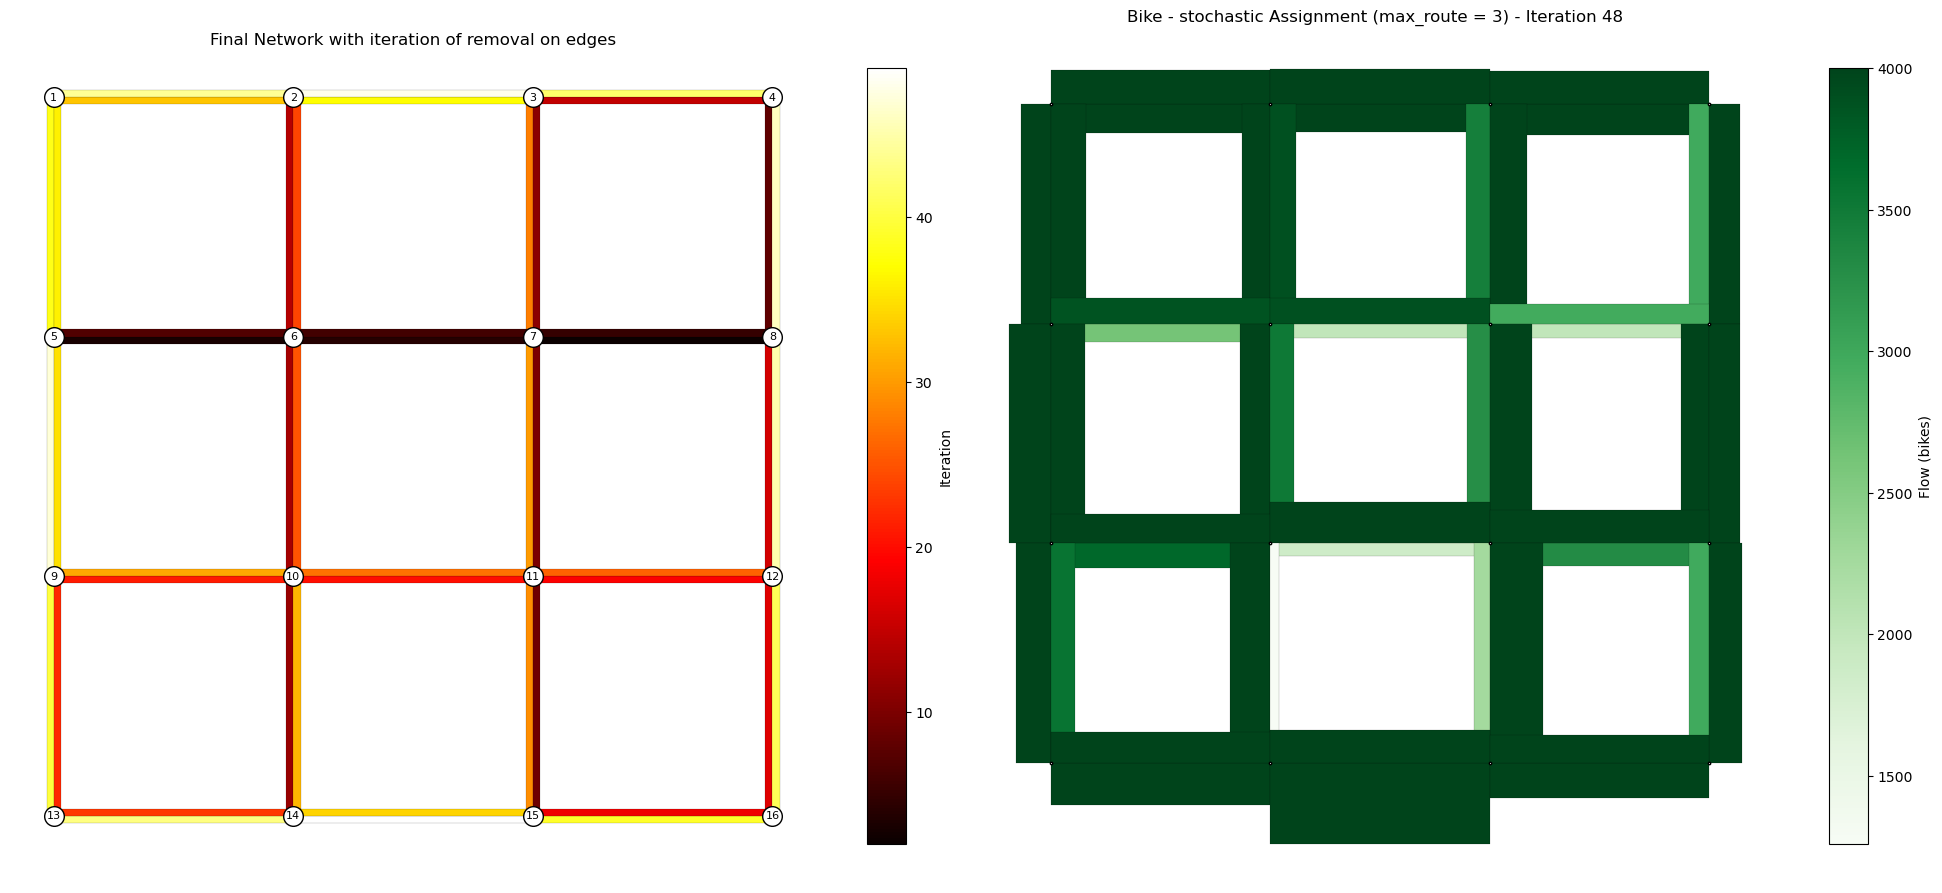

Proposed network with budget 10 has a flow coverage of 47.34%.


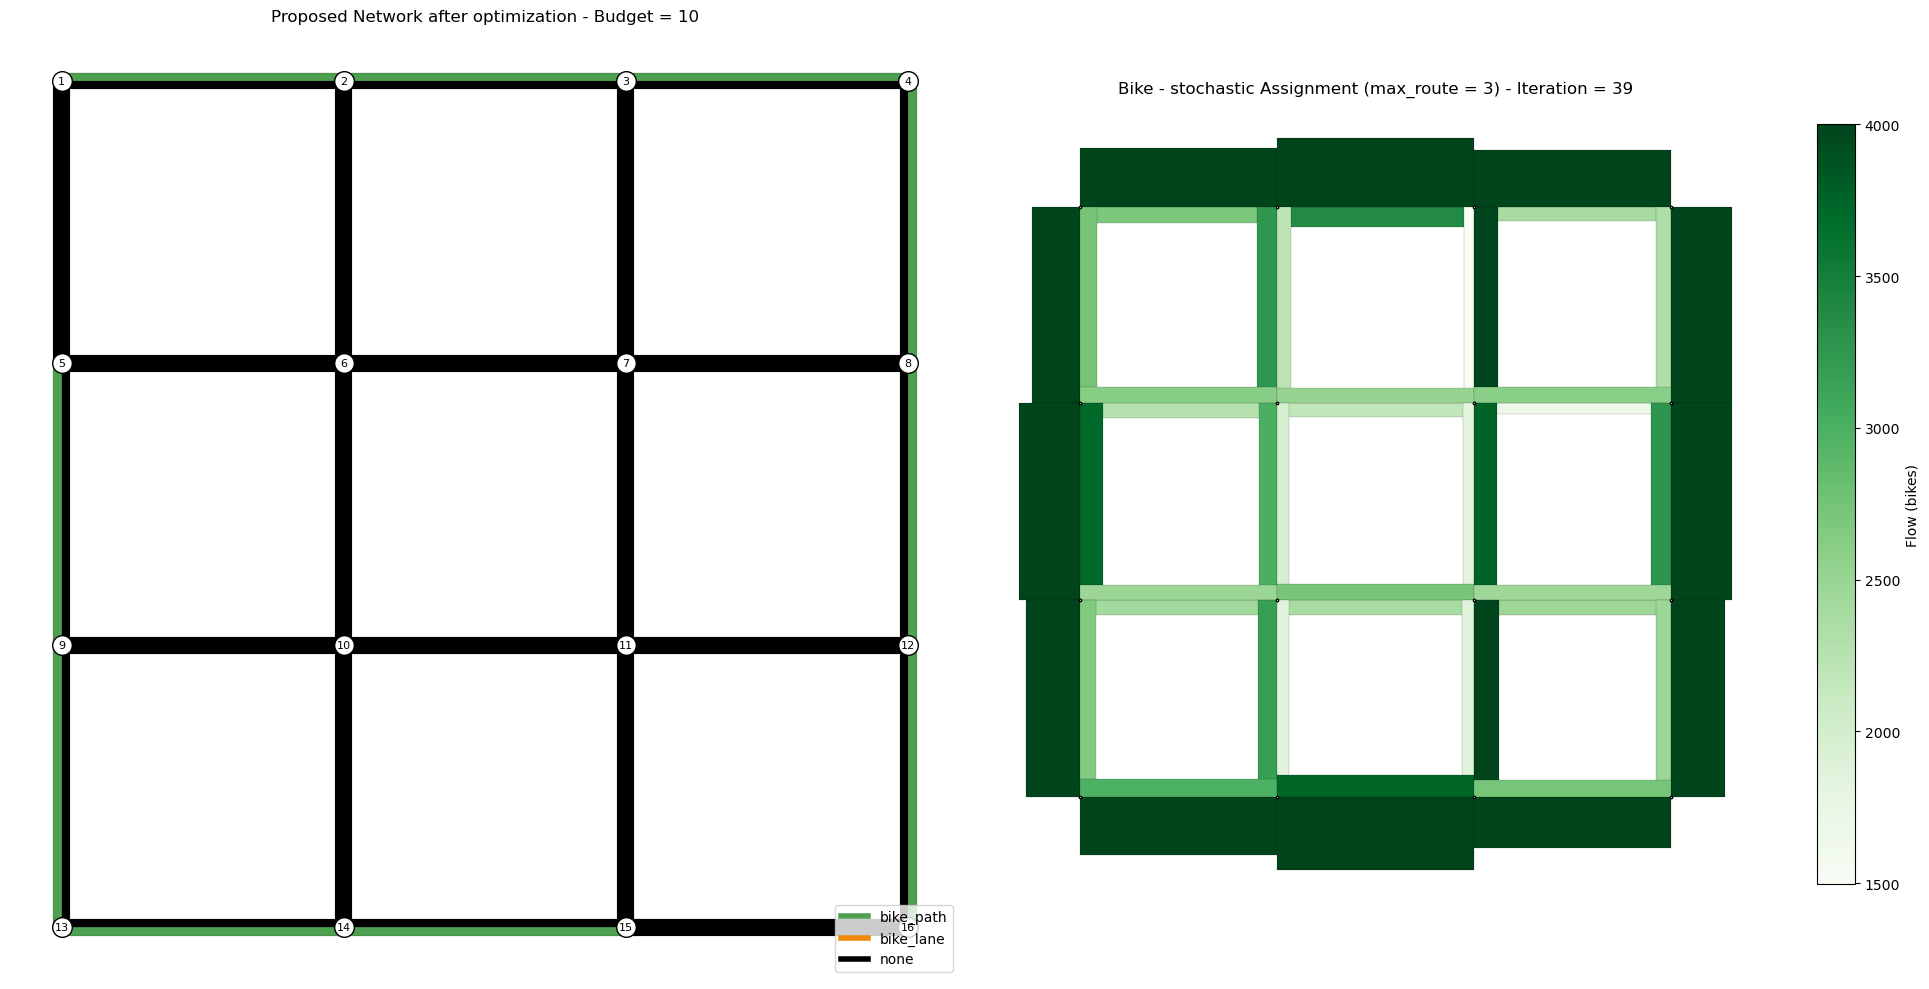

In [7]:
edge_df_final = edge_df_tri.copy()
results_df_exploded = results_df.explode('index_removed', ignore_index=True)
edge_df_final = pd.merge(edge_df_final, results_df_exploded[['iteration','index_removed']], left_index=True, right_on='index_removed', how='left')
fig, axes = plt.subplots(1,2, figsize=(20,5))
results_df.plot.line(x='iteration', y=['nbr_bike_lanes','nbr_none_bike_lanes'], title='Evolution of number of bike lanes', ax=axes[0])
results_df.plot.line(x='iteration', y='flow_of_removed_edge', title='Flow of removed bike lane', ax=axes[1])
plt.show()
fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_final, node_df, color_col_num='iteration', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,  title='Final Network with iteration of removal on edges', ax=axes[0], cmap='hot')
plot_network(
        bike_results['network'], node_df,
        width_col='flow',
        color_col_num='flow',
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration {i}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
plt.show()  
edge_df_proposed = edge_df_final.copy()


budget = 10
iteration = len(edge_df_proposed) - budget + 1
edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()

fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_proposed, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, title='Proposed Network after optimization - Budget = '+str(budget), figsize=(10,10), edges_label_col='index', ax=axes[0])
plot_network(
        edge_df_proposed, node_df,
        width_col='flow_bike_iteration_'+str(iteration),
        color_col_num='flow_bike_iteration_'+str(iteration),
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
print(f"Proposed network with budget {budget} has a flow coverage of {flow_coverage*100:.2f}%.")


# Loop 2
With mode choice (demande update), DUE for cars and congestion

Number of locked bike infrastructures: 3
Initial number of bike infrastructures: 48


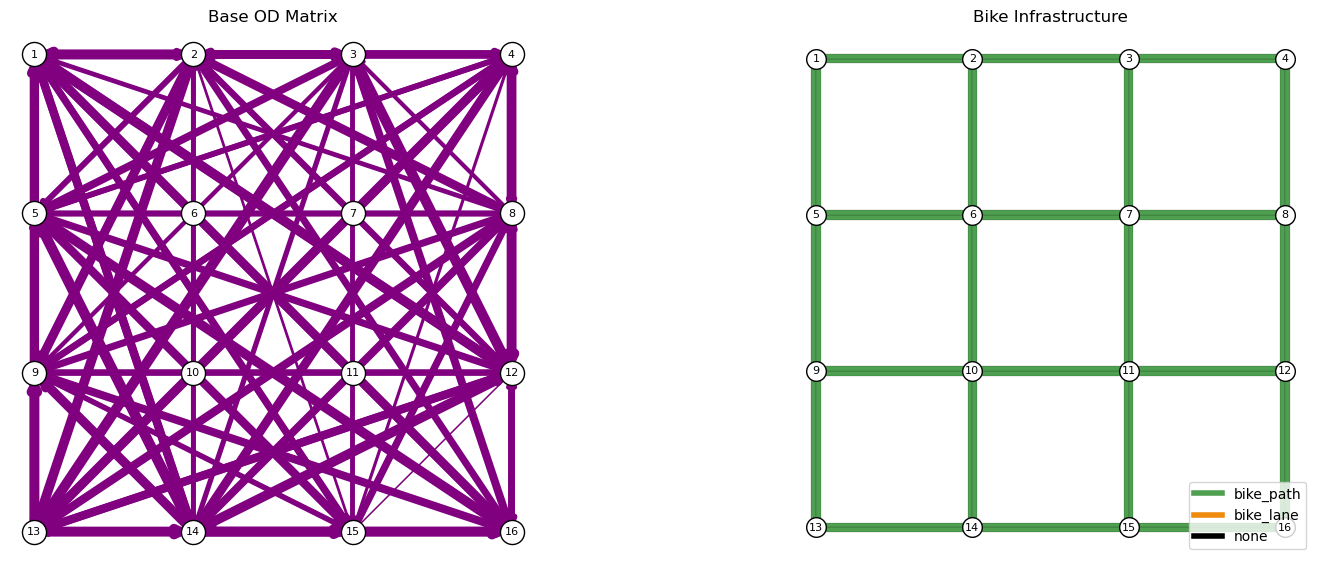

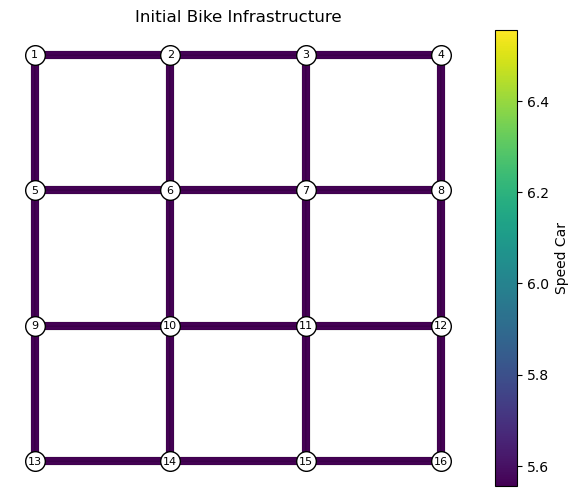


--- Iteration 1 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 1.97s | RGAP: 0.000617 | TTT: 66911740833


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 0
Mode shares with skimming: Car = 0.000 %, Bike = 100.000%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.01s | RGAP: 0.000000 | TTT: 0
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 1 - Removing bike lane on edge 43 with flow 4072.4396825396825

--- Iteration 2 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 1381501


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 1381514
Mode shares with skimming: Car = 0.137 %, Bike = 99.863%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 1381514
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 2 - Removing bike lane on edge 17 with flow 4116.228788198718

--- Iteration 3 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 1381514


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 1388773
Mode shares with skimming: Car = 0.137 %, Bike = 99.863%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 1388773
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 3 - Removing bike lane on edge 31 with flow 2424.530327925207

--- Iteration 4 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 1388773


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 4152050
Mode shares with skimming: Car = 0.228 %, Bike = 99.772%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 4152050
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 19 with flow 4190.840420825844 is locked and cannot be removed.
Iteration 4 - Removing bike lane on edge 47 with flow 4208.160748736708

--- Iteration 5 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 4151982


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 4962720
Mode shares with skimming: Car = 0.308 %, Bike = 99.692%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 4962720
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 5 - Removing bike lane on edge 37 with flow 3730.043574016776

--- Iteration 6 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 4962719


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 11960268
Mode shares with skimming: Car = 0.997 %, Bike = 99.003%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.05s | RGAP: 0.000000 | TTT: 11960268
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 19 with flow 3601.54234390286 is locked and cannot be removed.
Iteration 6 - Removing bike lane on edge 22 with flow 4084.164981968114

--- Iteration 7 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 11902206


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 11904117
Mode shares with skimming: Car = 0.992 %, Bike = 99.008%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 11904117
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 7 - Removing bike lane on edge 18 with flow 2607.269043061226

--- Iteration 8 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 11904057


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 11927718
Mode shares with skimming: Car = 0.992 %, Bike = 99.008%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 11927718
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 19 with flow 3601.54234390286 is locked and cannot be removed.
Iteration 8 - Removing bike lane on edge 14 with flow 4184.832122613083

--- Iteration 9 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 11927718


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 20934268
Mode shares with skimming: Car = 1.290 %, Bike = 98.710%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 20934268
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 19 with flow 3601.54234390286 is locked and cannot be removed.
Iteration 9 - Removing bike lane on edge 25 with flow 4191.553870354573

--- Iteration 10 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.05s | RGAP: 0.000000 | TTT: 20909404


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 20909721
Mode shares with skimming: Car = 1.289 %, Bike = 98.711%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 20909721
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 19 with flow 3712.9506772360937 is locked and cannot be removed.
Iteration 10 - Removing bike lane on edge 29 with flow 3889.8762326597334

--- Iteration 11 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.06s | RGAP: 0.000000 | TTT: 20909718


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 20935073
Mode shares with skimming: Car = 1.290 %, Bike = 98.710%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.09s | RGAP: 0.000000 | TTT: 20935073
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 11 - Removing bike lane on edge 33 with flow 3065.4565634550468

--- Iteration 12 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 20935073


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 30587347
Mode shares with skimming: Car = 1.608 %, Bike = 98.392%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 30587347
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 12 - Removing bike lane on edge 7 with flow 4657.961020732921

--- Iteration 13 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.06s | RGAP: 0.000000 | TTT: 30552205


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 30552744
Mode shares with skimming: Car = 1.607 %, Bike = 98.393%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 30552744
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 13 - Removing bike lane on edge 20 with flow 3411.008624358465

--- Iteration 14 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 30552737


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 30571362
Mode shares with skimming: Car = 1.608 %, Bike = 98.392%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 30571362
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 14 - Removing bike lane on edge 34 with flow 2970.6959310017264

--- Iteration 15 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 30571362


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 37669685
Mode shares with skimming: Car = 1.842 %, Bike = 98.158%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.08s | RGAP: 0.000000 | TTT: 37669685
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 15 - Removing bike lane on edge 44 with flow 4265.029288613527

--- Iteration 16 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 37662143


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 46240379
Mode shares with skimming: Car = 2.488 %, Bike = 97.512%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 46240379
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 16 - Removing bike lane on edge 27 with flow 5182.782058476173

--- Iteration 17 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 46157282


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 46160091
Mode shares with skimming: Car = 2.483 %, Bike = 97.517%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 46160091
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 17 - Removing bike lane on edge 40 with flow 3066.46619343341

--- Iteration 18 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 46160000


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 46179245
Mode shares with skimming: Car = 2.484 %, Bike = 97.516%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.05s | RGAP: 0.000000 | TTT: 46179245
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 18 - Removing bike lane on edge 13 with flow 3494.8749465434576

--- Iteration 19 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 46179245


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 53510405
Mode shares with skimming: Car = 2.726 %, Bike = 97.274%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 53510405
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 19 with flow 4229.791606208695 is locked and cannot be removed.
Edge 15 with flow 4328.7929458327335 is locked and cannot be removed.
Edge 11 with flow 4492.785934735898 is locked and cannot be removed.
Iteration 19 - Removing bike lane on edge 6 with flow 6898.422258656162

--- Iteration 20 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 53501572


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.07s | RGAP: 0.000000 | TTT: 62666122
Mode shares with skimming: Car = 3.626 %, Bike = 96.374%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 62666122
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 20 - Removing bike lane on edge 9 with flow 3974.3680775004627

--- Iteration 21 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 65253921


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.13s | RGAP: 0.000000 | TTT: 74339076
Mode shares with skimming: Car = 4.636 %, Bike = 95.364%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.09s | RGAP: 0.000000 | TTT: 74339076
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 21 - Removing bike lane on edge 3 with flow 4775.310935226542

--- Iteration 22 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 74241354


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 97883005
Mode shares with skimming: Car = 5.865 %, Bike = 94.135%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 97883005
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 22 - Removing bike lane on edge 0 with flow 5805.57308358138

--- Iteration 23 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 119873823


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.07s | RGAP: 0.000000 | TTT: 132438959
Mode shares with skimming: Car = 7.876 %, Bike = 92.124%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 132438959
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 23 - Removing bike lane on edge 10 with flow 5303.910334736438

--- Iteration 24 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.08s | RGAP: 0.000000 | TTT: 132010250


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 134456311
Mode shares with skimming: Car = 8.100 %, Bike = 91.900%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 134456311
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 24 - Removing bike lane on edge 28 with flow 7884.708622363636

--- Iteration 25 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 134443012


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 134445227
Mode shares with skimming: Car = 8.100 %, Bike = 91.900%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 134445227
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 25 - Removing bike lane on edge 4 with flow 6020.274443330818

--- Iteration 26 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 134444860


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 134558968
Mode shares with skimming: Car = 8.103 %, Bike = 91.897%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 134558968
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 26 - Removing bike lane on edge 16 with flow 5333.947279313426

--- Iteration 27 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 134547641


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 134556765
Mode shares with skimming: Car = 8.103 %, Bike = 91.897%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 134556765
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 27 - Removing bike lane on edge 30 with flow 6343.467844741001

--- Iteration 28 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 134556494


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 137371656
Mode shares with skimming: Car = 8.196 %, Bike = 91.804%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 137371656
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 28 - Removing bike lane on edge 41 with flow 8315.761716950235

--- Iteration 29 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 137371576


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 146148521
Mode shares with skimming: Car = 8.541 %, Bike = 91.459%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000000 | TTT: 146148521
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 29 - Removing bike lane on edge 38 with flow 8469.22463116289

--- Iteration 30 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000000 | TTT: 165918593


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 195054847
Mode shares with skimming: Car = 11.269 %, Bike = 88.731%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.02s | RGAP: 0.000000 | TTT: 195054847
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Edge 11 with flow 8155.294335035789 is locked and cannot be removed.
Iteration 30 - Removing bike lane on edge 36 with flow 8925.185603018204

--- Iteration 31 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 1.82s | RGAP: 0.000518 | TTT: 379624855


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.04s | RGAP: 0.000075 | TTT: 283520610
Mode shares with skimming: Car = 14.359 %, Bike = 85.641%
➡️ Running traffic assignments...
➡️ Cars assignment...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

DUE completed in 0.03s | RGAP: 0.000075 | TTT: 283520610
✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 31 - Removing bike lane on edge 32 with flow 7225.460164091363

--- Iteration 32 ---
➡️ Running mode choice...


car                                               :   0%|          | 0/16 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")
edge_df = calculate_length(node_df, edge_df)
edge_df['length'] *= 10
edge_df_tri=edge_df.copy().reset_index(drop=True)
edge_df_tri['lock_bike_infra']=False
edge_df_tri['type_bike']= None

np.random.seed(69)


od_type = 'custom'

od_matrix = pd.DataFrame(0, index=range(1,max(node_df['node'])+1), columns=range(1,max(node_df['node'])+1))
if od_type == 'random':
    od_matrix.loc[1,16] = 3000
    od_matrix.loc[13,4] = 3000
elif od_type == 'scenario_1':
    od_matrix.loc[1,16]= 3000
elif od_type == 'scenario_2':
    od_matrix.loc[1,16]= 3000
    od_matrix.loc[13,4]= 3000
elif od_type == 'scenario_3':
    od_matrix.loc[1,16]= 3000
    od_matrix.loc[13,4]= 3000
    edge_df_tri = lock_infra(edge_df_tri,5,6)
    edge_df_tri = lock_infra(edge_df_tri,6,7)
    edge_df_tri = lock_infra(edge_df_tri,7,8)
elif od_type == 'scenario_4':
    liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
    for i in liste_i:
        for j in liste_i:
            if i != j:
                od_matrix.loc[i,j] = np.random.randint(20,500)
    edge_df_tri = lock_infra(edge_df_tri,5,6)
    edge_df_tri = lock_infra(edge_df_tri,6,7)
    edge_df_tri = lock_infra(edge_df_tri,7,8)
else :
    liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
    for i in liste_i:
        for j in liste_i:
            if i != j:
                od_matrix.loc[i,j] = np.random.randint(20,1500)
    edge_df_tri = lock_infra(edge_df_tri,5,6)
    edge_df_tri = lock_infra(edge_df_tri,6,7)
    edge_df_tri = lock_infra(edge_df_tri,7,8)


fig, axes = plt.subplots(1,2, figsize=(16,6))
plot_od_matrix(convert_to_eaquilibrae_od_matrix(od_matrix), edge_df_tri, node_df, label=False, title='Base OD Matrix', color='purple', vmax=1000, figsize=(6,6), ax=axes[0])

for edge in edge_df.itertuples():
    edge_df_tri = change_type_bike(edge_df_tri, edge.a_node, edge.b_node, 'bike_path')


# counter
i = 0
limit = 100

# parameters for stochastic assignment
beta = 1
cutoff_prob = 0.0

# parameters for mode choice
beta_time = -0.01
ASC_car = 0
ASC_bike = -2.5

impact_coef = 1
mu_mode = 1.0
loop_count = 2

plot = False
# other parameters

edge_df_tri["flow_car"] = 0
edge_df_tri["flow_bike"] = 0

edge_df_tri["capacity_bikes"]= 9999

for edge in edge_df_tri.itertuples():
    if edge.type_car == 'primary':
        edge_df_tri.loc[edge.Index, 'capacity_cars'] = 2000
    elif edge.type_car == 'motorway':
        edge_df_tri.loc[edge.Index, 'capacity_cars'] = 8000
        edge_df_tri.loc[edge.Index, 'capacity_bike'] = 0
        edge_df_tri.loc[edge.Index, 'type_bike'] = None
        edge_df_tri.loc[edge.Index, 'lock_bike_infra'] = True
        edge_df_tri.loc[edge.Index, 'speed_car'] = 130
    else:
        edge_df_tri.loc[edge.Index, 'capacity_cars'] = 9999

edge_df_tri["speed_car"] = edge_df_tri["speed_car"] / 3.6
edge_df_tri["speed_bike"] = edge_df_tri["speed_bike"] / 3.6

plot_network(edge_df_tri, node_df, color_col_num='speed_car', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,title='Initial Bike Infrastructure', figsize=(6,6), edges_label_col='index')

edge_df_tri["alpha"]=0.15
edge_df_tri["beta"]=4.0

edge_df_tri = free_flow_time(edge_df_tri, 'car')
edge_df_tri = free_flow_time(edge_df_tri, 'bike')
edge_df_tri["length_bi"] = edge_df_tri["length"]

edge_df_tri["travel_time_car"] = edge_df_tri['free_flow_time_car']
edge_df_tri["travel_time_bike"] = edge_df_tri['free_flow_time_bike']
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()

results_df_mc = pd.DataFrame({'iteration_loop': [0],
                              'iteration_mode_choice': [0],
                            'modal_share_car': [np.nan],
                            'modal_share_bike': [np.nan],
                            'total_travel_time_car': [np.nan],
                            'total_travel_time_bike': [np.nan],
                            'travel_time_per_car': [np.nan],
                            'travel_time_per_bike': [np.nan]})

results_df = pd.DataFrame({'iteration': [0],
                        'nbr_bike_lanes': nbr_bike_lanes,
                        'nbr_none_bike_lanes': nbr_none_bike_lanes,
                        'modal_share_car': [np.nan],
                        'modal_share_bike': [np.nan]})


nbr_locked_infra = len(edge_df_tri[edge_df_tri['lock_bike_infra']==True])
print(f"Number of locked bike infrastructures: {nbr_locked_infra}")
print(f"Initial number of bike infrastructures: {nbr_bike_lanes}")
plot_network(edge_df_tri, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,title='Bike Infrastructure', figsize=(6,6), edges_label_col='index', ax=axes[1])
plt.show()

while nbr_bike_lanes > nbr_locked_infra and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    

    # mode choice adjustment
    j = 0

    print("➡️ Running mode choice...")
    while j < loop_count:
        if plot:
            print(f"\n--- Mode Choice Loop {j+1} ---")
        j += 1
        
        size_od = od_matrix.index.max()
        #create skim matrices
        skim_car = np.zeros((size_od,size_od))
        skim_bike = np.zeros((size_od,size_od))

        # Car skimming using current edge travel times
        G_car = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_car.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_car'])

        for origin in range(1, size_od+1):
            for destination in range(1, size_od+1):
                if origin != destination:
                    try:
                        skim_car[origin-1, destination-1] = nx.shortest_path_length(G_car, source=origin, target=destination, weight='time')
                    except:
                        skim_car[origin-1, destination-1] = 9999

        # Bike skimming using current edge travel times with length_bi
        
        G_bike = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_bike.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_bike'])

        for origin in range(1, size_od+1):
            for destination in range(1, size_od+1):
                if origin != destination:
                    try:
                        skim_bike[origin-1, destination-1] = nx.shortest_path_length(G_bike, source=origin, target=destination, weight='time')
                    except:
                        skim_bike[origin-1, destination-1] = 9999

        # Calculate utilities and mode share for each OD pair
        od_mode_shares_skim = np.zeros((size_od,size_od,2)) # 3rd dimension: 0 for car, 1 for bike
        total_car_skim = 0
        total_bike_skim = 0

        for origin in range(1, size_od+1):
            for destination in range(1, size_od+1):
                if origin != destination and od_matrix.loc[origin, destination] > 0:
                    # Utilities
                    V_car = ASC_car + beta_time * skim_car[origin-1, destination-1]
                    V_bike = ASC_bike + beta_time * skim_bike[origin-1, destination-1] # TO MODIFY FOR AN OTHER UTILITY FUNCTION

                    # Probabilities using logit model
                    exp_car = np.exp(mu_mode * V_car)
                    exp_bike = np.exp(mu_mode * V_bike)
                    P_car = exp_car / (exp_car + exp_bike)
                    P_bike = exp_bike / (exp_car + exp_bike)

                    od_mode_shares_skim[origin-1, destination-1, 0] = P_car
                    od_mode_shares_skim[origin-1, destination-1, 1] = P_bike

                    # Accumulate total mode shares
                    total_car_skim += od_matrix.loc[origin, destination] * P_car
                    total_bike_skim += od_matrix.loc[origin, destination] * P_bike
        if plot:            
            print(f"Mode shares with skimming: Car = {total_car_skim/(total_car_skim+total_bike_skim)*100 :.3f} %, Bike = {total_bike_skim/(total_car_skim+total_bike_skim)*100:.3f}%")
        # Update OD matrices based on mode shares
        updated_od_car = pd.DataFrame(0, index=range(1,size_od+1), columns=range(1,size_od+1))
        updated_od_bike = pd.DataFrame(0, index=range(1,size_od+1), columns=range(1,size_od+1))

        for origin in range(1, size_od+1):
            for destination in range(1, size_od+1):
                if origin != destination:
                    total_od = od_matrix.loc[origin, destination]
                    P_car = od_mode_shares_skim[origin-1, destination-1, 0]
                    P_bike = od_mode_shares_skim[origin-1, destination-1, 1]
                    updated_od_car.loc[origin, destination] = total_od * P_car
                    updated_od_bike.loc[origin, destination] = total_od * P_bike
        
        updated_od_car = convert_to_eaquilibrae_od_matrix(updated_od_car)
        updated_od_bike = convert_to_eaquilibrae_od_matrix(updated_od_bike)

        #run traffic assignments with updated OD matrices
        car_results_mode_choice = ta_due(
                                    edge_df_tri,
                                    updated_od_car,
                                    algorithm='bfw',
                                    time_field='travel_time_car',
                                    cost_field='length',
                                    max_iter=500,
                                    tolerance=1e-4,
                                    capacity_field='capacity_cars'
                                    )
        
        edge_df_tri = car_results_mode_choice['network'].copy()
        edge_df_tri["flow_car"] = edge_df_tri["flow"]
        edge_df_tri["ratio_flow_capacity_car"] = edge_df_tri["ratio"]
        edge_df_tri = pd.DataFrame.from_dict(edge_df_tri)
        if plot :
            plot_vc_histogram(edge_df_tri, capacity_col='capacity_cars', bins=20)

        edge_df_tri = simple_bi_3(edge_df_tri, traffic_car_col='flow_car', coef=impact_coef)
        edge_df_tri['travel_time_bike'] = edge_df_tri['length_bi']/edge_df_tri['speed_bike']

        bike_results_mode_choice = ta_stochastic(
                                    edge_df_tri, 
                                    updated_od_bike, 
                                    mode='bikes',
                                    time_field='travel_time_bike', 
                                    cost_field='length_bi', ### LENGTH OR LENGTH_BI?
                                    algorithm='bfsle', 
                                    max_routes=3,
                                    capacity_field='capacity_bikes',
                                    beta=beta,
                                    cutoff_prob=cutoff_prob
                                    )
        
        edge_df_tri = bike_results_mode_choice['network'].copy()
        edge_df_tri["flow_bike"]= edge_df_tri["flow"]
        edge_df_tri = pd.DataFrame.from_dict(edge_df_tri)

        #calculate congested time for cars
        calculate_congested_time(edge_df_tri, flow_name='flow_car',free_flow_time_name='free_flow_time_car', capacity_name="capacity_cars", congested_time_name='travel_time_car', alpha=0.15, beta=4)
        if plot:
            fig, axes = plt.subplots(2,2, figsize=(10,10))
            plot_network(edge_df_tri, node_df, width_col='flow_car', color_col_num='flow_car', cmap='Reds', title=f'Car flows- Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (cars)', base_width=1, width_scale=50, ax=axes[0,0])
            plot_network(edge_df_tri, node_df, width_col='flow_bike', color_col_num='flow_bike', cmap='Greens', title=f'Bike flows - Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (bikes)', base_width=1, width_scale=50, ax=axes[0,1])
            plot_network(edge_df_tri, node_df, color_col_num='travel_time_car', cmap='hot_r', title=f'Car Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,0])
            plot_network(edge_df_tri, node_df, color_col_num='travel_time_bike', cmap='hot_r', title=f'Bike Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,1])
            plt.show()
            plot_network(edge_df_tri, node_df, color_col_num='length_bi', base_width=1, legend=True,  node_label=True,title=f'length_bi - Loop {j}', figsize=(5,5), edges_label_col='index', cmap='viridis_r')
            plt.show()
        
        total_travel_time_car = (edge_df_tri['travel_time_car'] * edge_df_tri['flow_car']).sum()
        total_travel_time_bike = (edge_df_tri['travel_time_bike'] * edge_df_tri['flow_bike']).sum()

        results_df_mc = pd.concat([results_df_mc, pd.DataFrame({'iteration_loop': [i],
                                              'iteration_mode_choice': j,
                                              'modal_share_car': 100*total_car_skim / od_matrix.values.sum(),
                                              'modal_share_bike': 100*total_bike_skim / od_matrix.values.sum(),
                                              'total_travel_time_car': total_travel_time_car,
                                              'total_travel_time_bike': total_travel_time_bike,
                                              'travel_time_per_car': total_travel_time_car / updated_od_car.values.sum(),
                                              'travel_time_per_bike': total_travel_time_bike / updated_od_bike.values.sum()})], ignore_index=True)

    print(f"Mode shares with skimming: Car = {total_car_skim/(total_car_skim+total_bike_skim)*100 :.3f} %, Bike = {total_bike_skim/(total_car_skim+total_bike_skim)*100:.3f}%")
    od_bike = updated_od_bike.copy()
    od_car = updated_od_car.copy()

    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")

    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # run car traffic assignment
    cars_results = ta_due(edge_df_tri,
                          od_car,
                          algorithm='bfw',
                          time_field='travel_time_car',
                          cost_field='length',
                          max_iter=500,
                          tolerance=1e-4,
                          capacity_field='capacity_cars'
                          )
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_3(edge_df_tri, traffic_car_col=name_col_flow_car, coef=impact_coef)

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='free_flow_time_bike', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta,
                                cutoff_prob=cutoff_prob
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("✅ Traffic assignments completed.")

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index
    
    #remove infrastructures from selected edges
    for index in index_least_used:
        if not edge_df_tri.loc[index, 'lock_bike_infra']:
            print(f"Iteration {i} - Removing bike lane on edge {index} with flow {edge_df_tri.loc[index, name_col_flow_bike]}")
            edge_df_tri.loc[index, 'type_bike'] = None
            flow_of_removed_edge = edge_df_tri.loc[index, name_col_flow_bike]
            results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [int(i+1)],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [index],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)
            break
        else:
            print(f"Edge {index} with flow {edge_df_tri.loc[index, name_col_flow_bike]} is locked and cannot be removed.")
    
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    iteration_finale = i
    

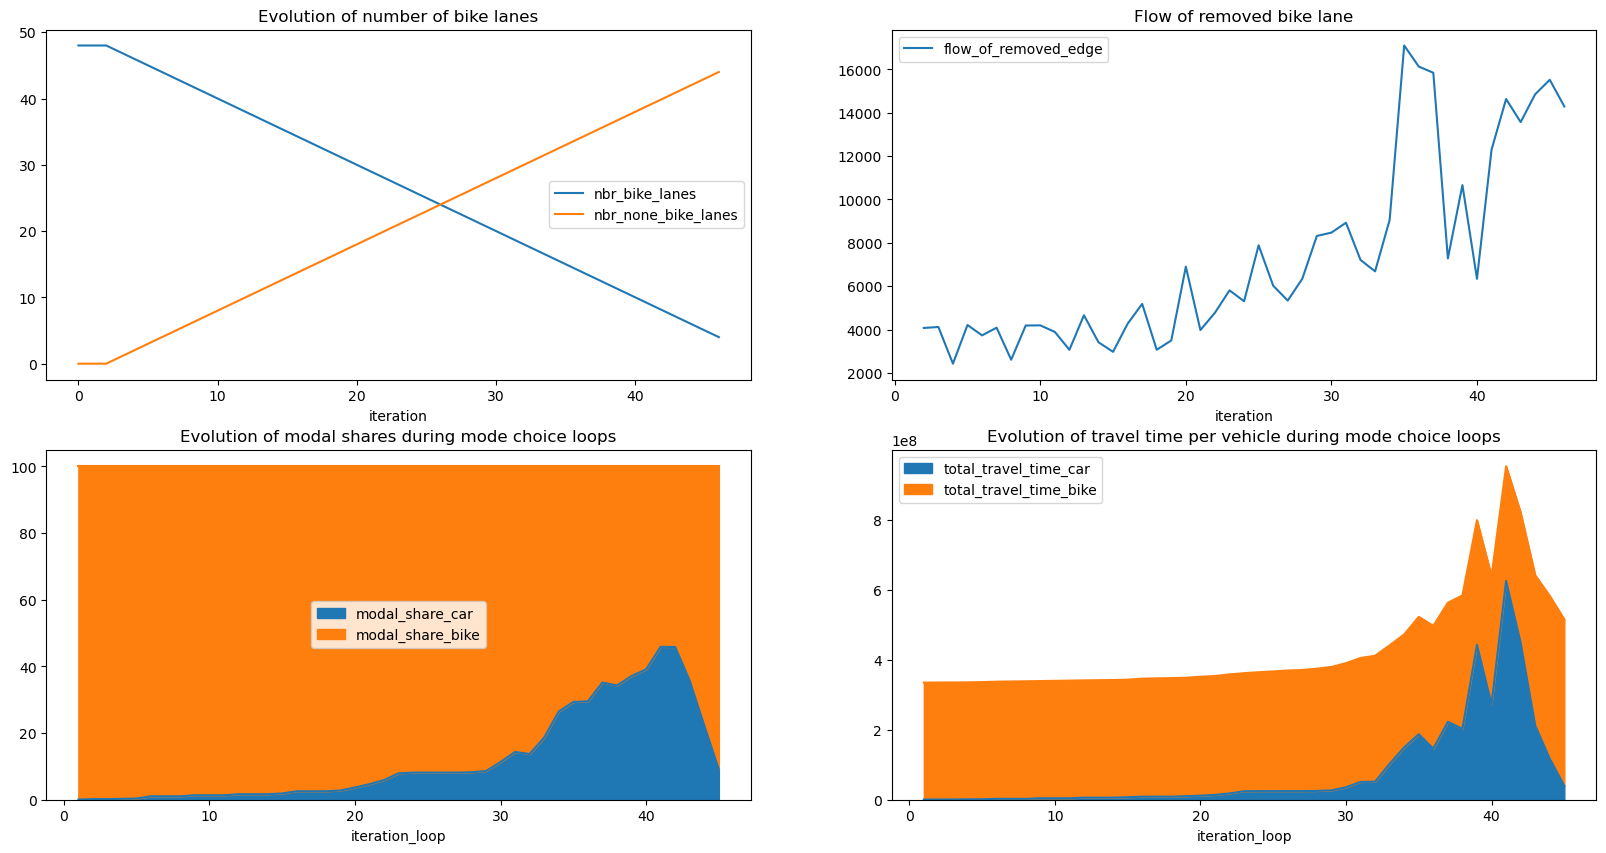

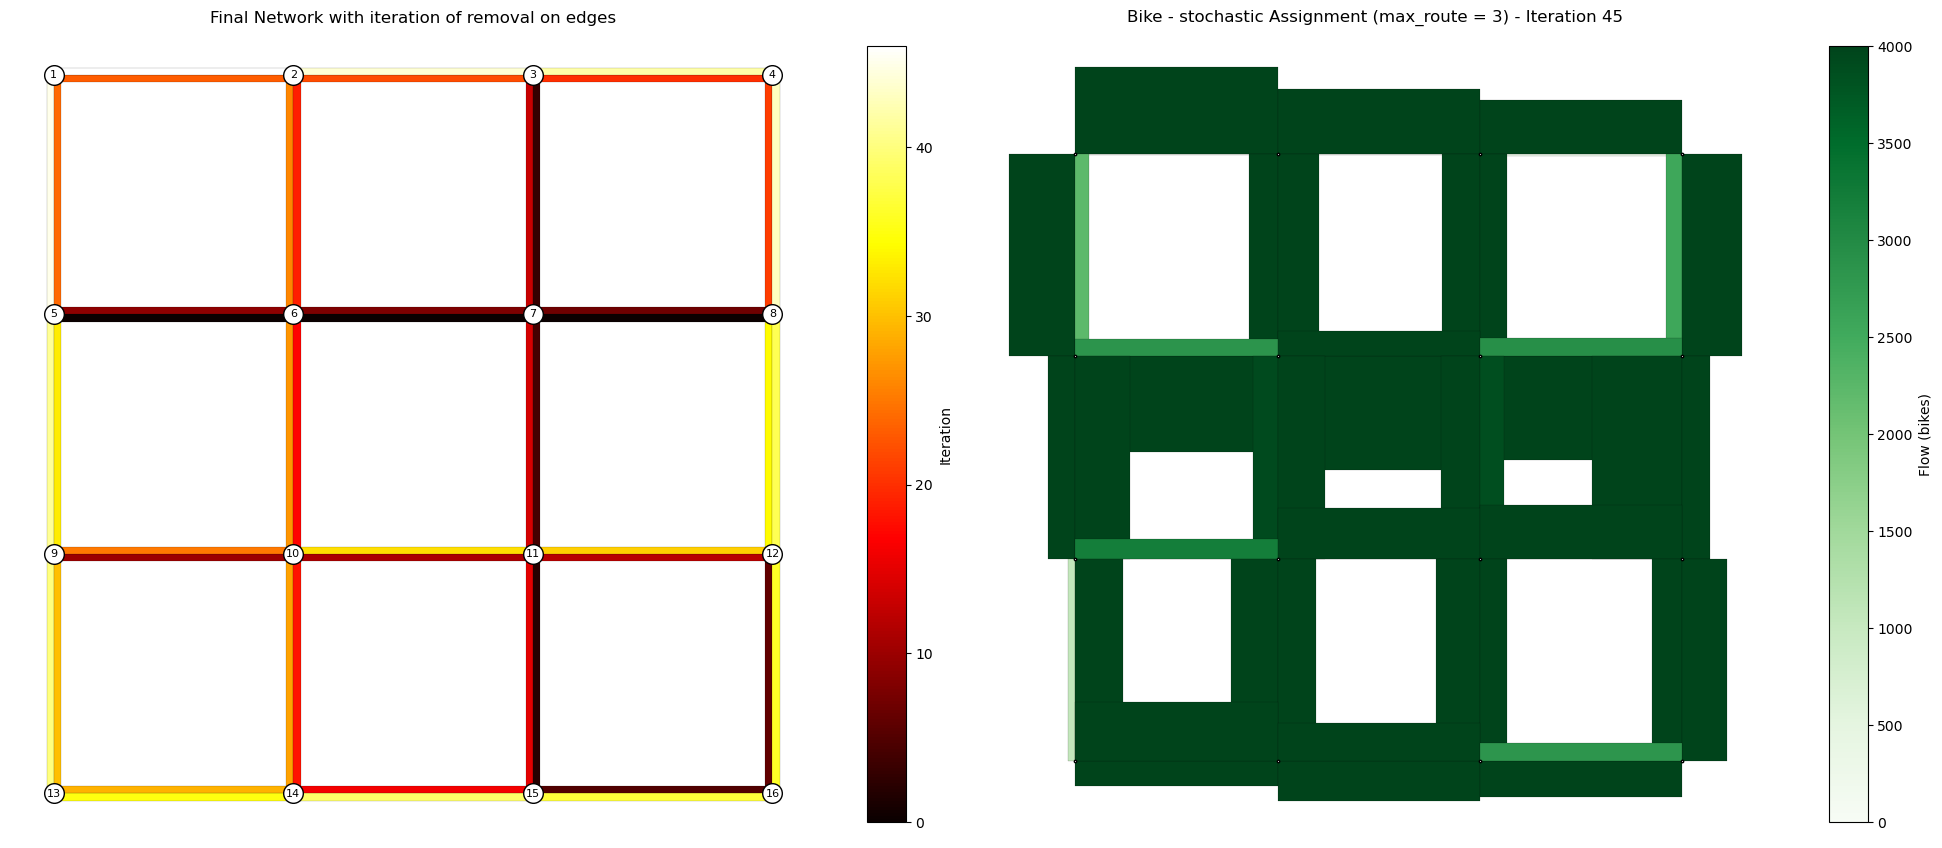

ValueError: minvalue must be less than or equal to maxvalue

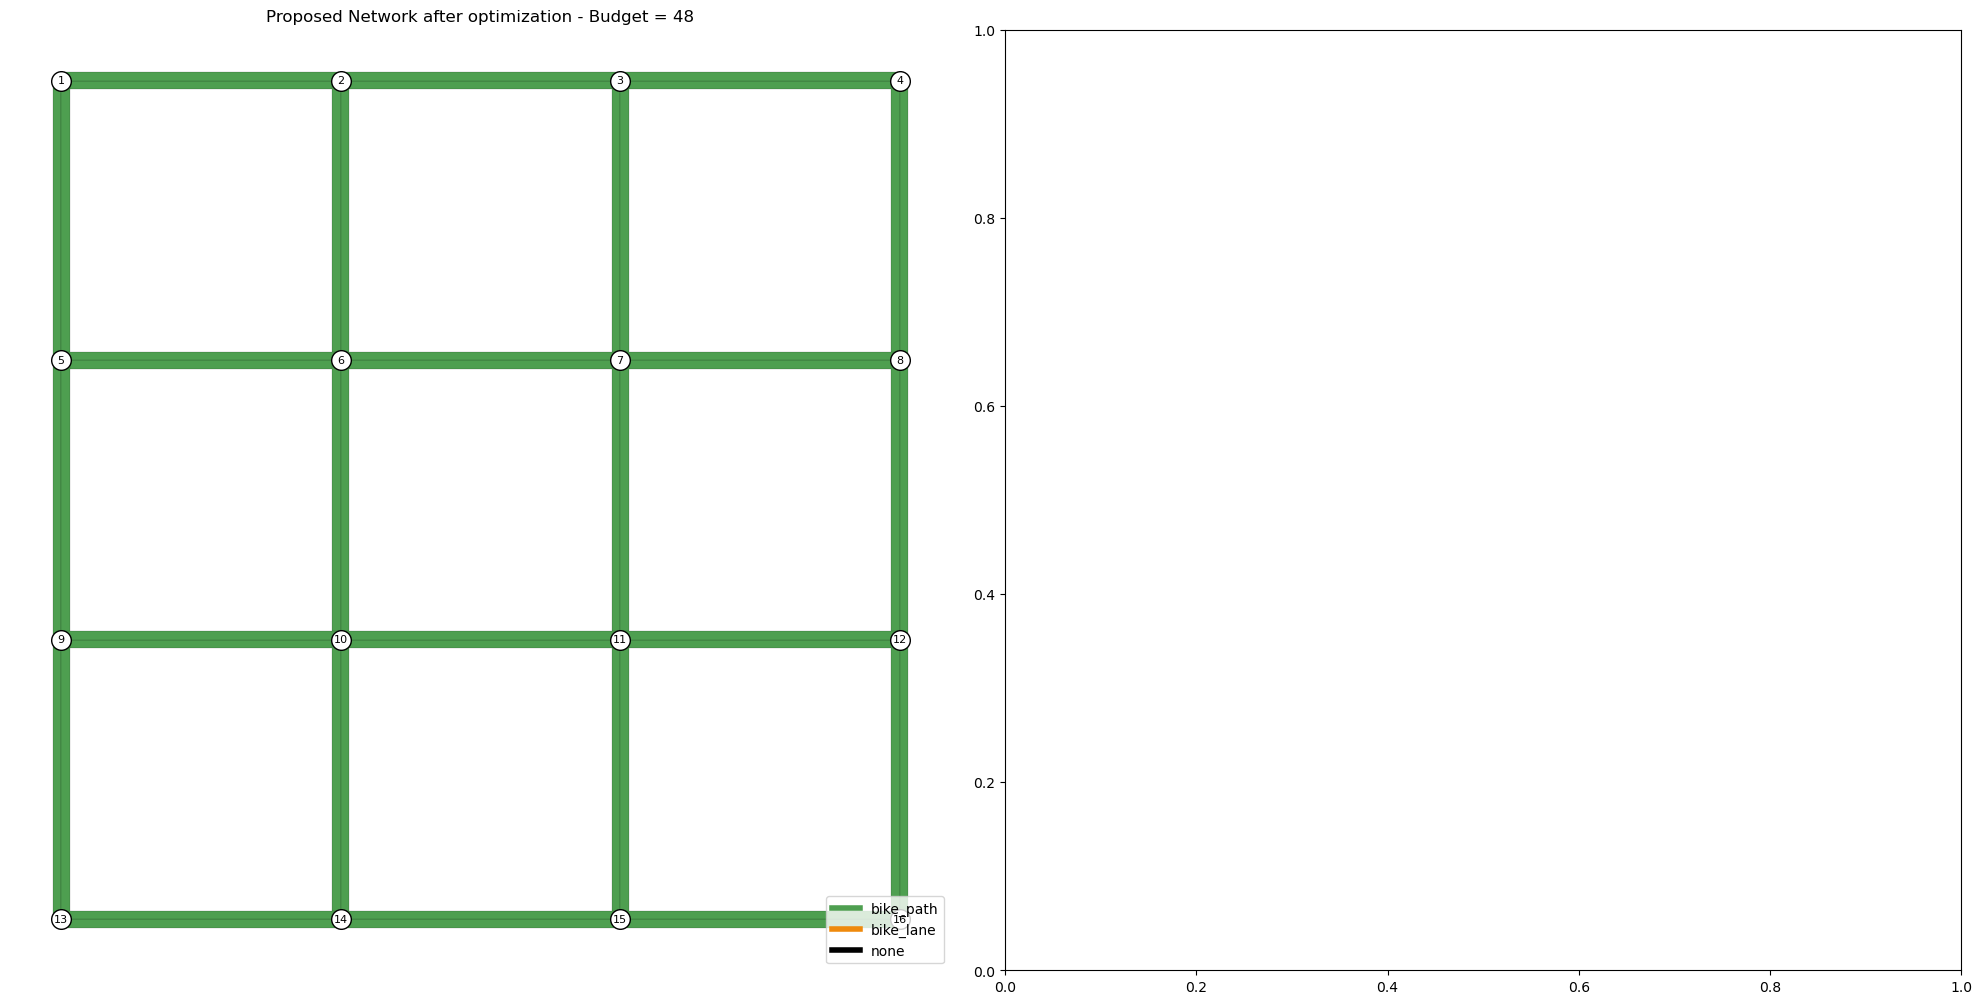

In [7]:
edge_df_final = edge_df_tri.copy()
results_df_exploded = results_df.explode('index_removed', ignore_index=True)
edge_df_final = pd.merge(edge_df_final, results_df_exploded[['iteration','index_removed']], left_index=True, right_on='index_removed', how='left')
results_df_mc_final = results_df_mc[results_df_mc['iteration_mode_choice']==2]
results_df_mc_final['total_travel_time'] = results_df_mc_final['total_travel_time_car'] + results_df_mc_final['total_travel_time_bike']
fig, axes = plt.subplots(2,2, figsize=(20,10))
results_df.plot.line(x='iteration', y=['nbr_bike_lanes','nbr_none_bike_lanes'], title='Evolution of number of bike lanes', ax=axes[0,0])
results_df.plot.line(x='iteration', y='flow_of_removed_edge', title='Flow of removed bike lane', ax=axes[0,1])
results_df_mc_final.plot.area(x='iteration_loop', y=['modal_share_car','modal_share_bike'], title='Evolution of modal shares during mode choice loops', ax=axes[1,0])
results_df_mc_final.plot.area(x='iteration_loop', y=['total_travel_time_car','total_travel_time_bike'], title='Evolution of travel time per vehicle during mode choice loops', ax=axes[1,1])
plt.show()
fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_final, node_df, color_col_num='iteration', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,  title='Final Network with iteration of removal on edges', ax=axes[0], cmap='hot')
plot_network(
        bike_results['network'], node_df,
        width_col='flow',
        color_col_num='flow',
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration {i}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
plt.show()  
edge_df_proposed = edge_df_final.copy()


budget = 48
iteration = len(edge_df_proposed) - budget + 1
edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()

fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_proposed, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, title='Proposed Network after optimization - Budget = '+str(budget), figsize=(10,10), edges_label_col='index', ax=axes[0])
plot_network(
        edge_df_proposed, node_df,
        width_col='flow_bike_iteration_'+str(iteration),
        color_col_num='flow_bike_iteration_'+str(iteration),
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
print(f"Proposed network with budget {budget} has a flow coverage of {flow_coverage*100:.2f}%.")


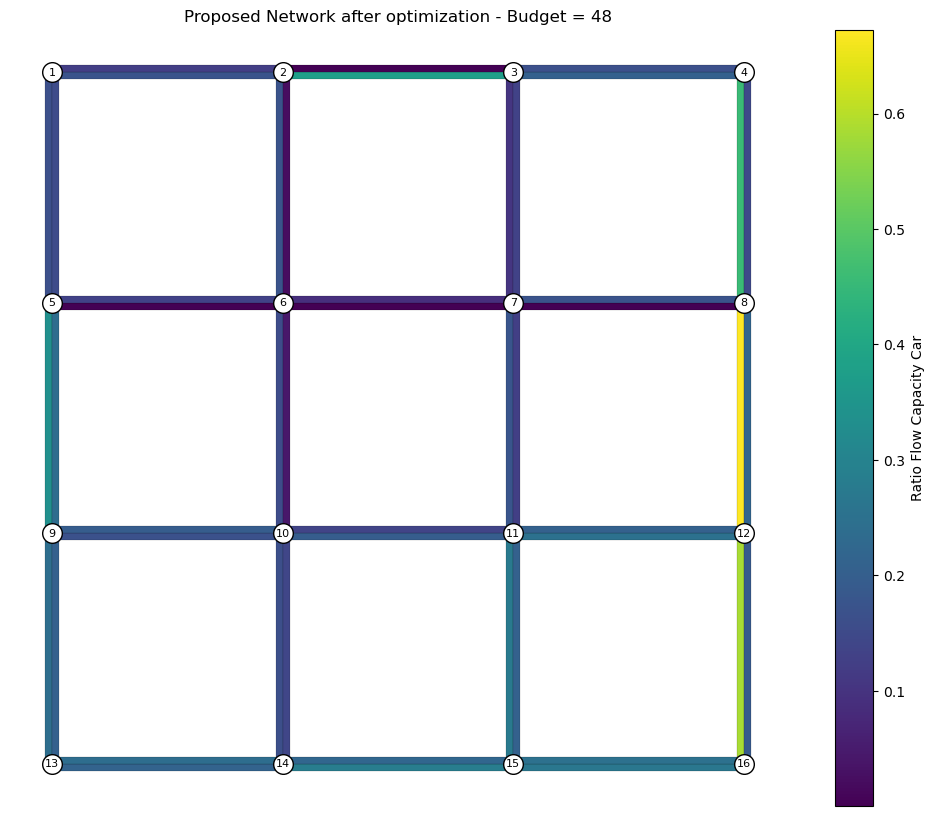

In [111]:
plot_network(edge_df_tri, node_df,color_col_num='ratio_flow_capacity_car', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, title='Proposed Network after optimization - Budget = '+str(budget), figsize=(10,10), edges_label_col='index')

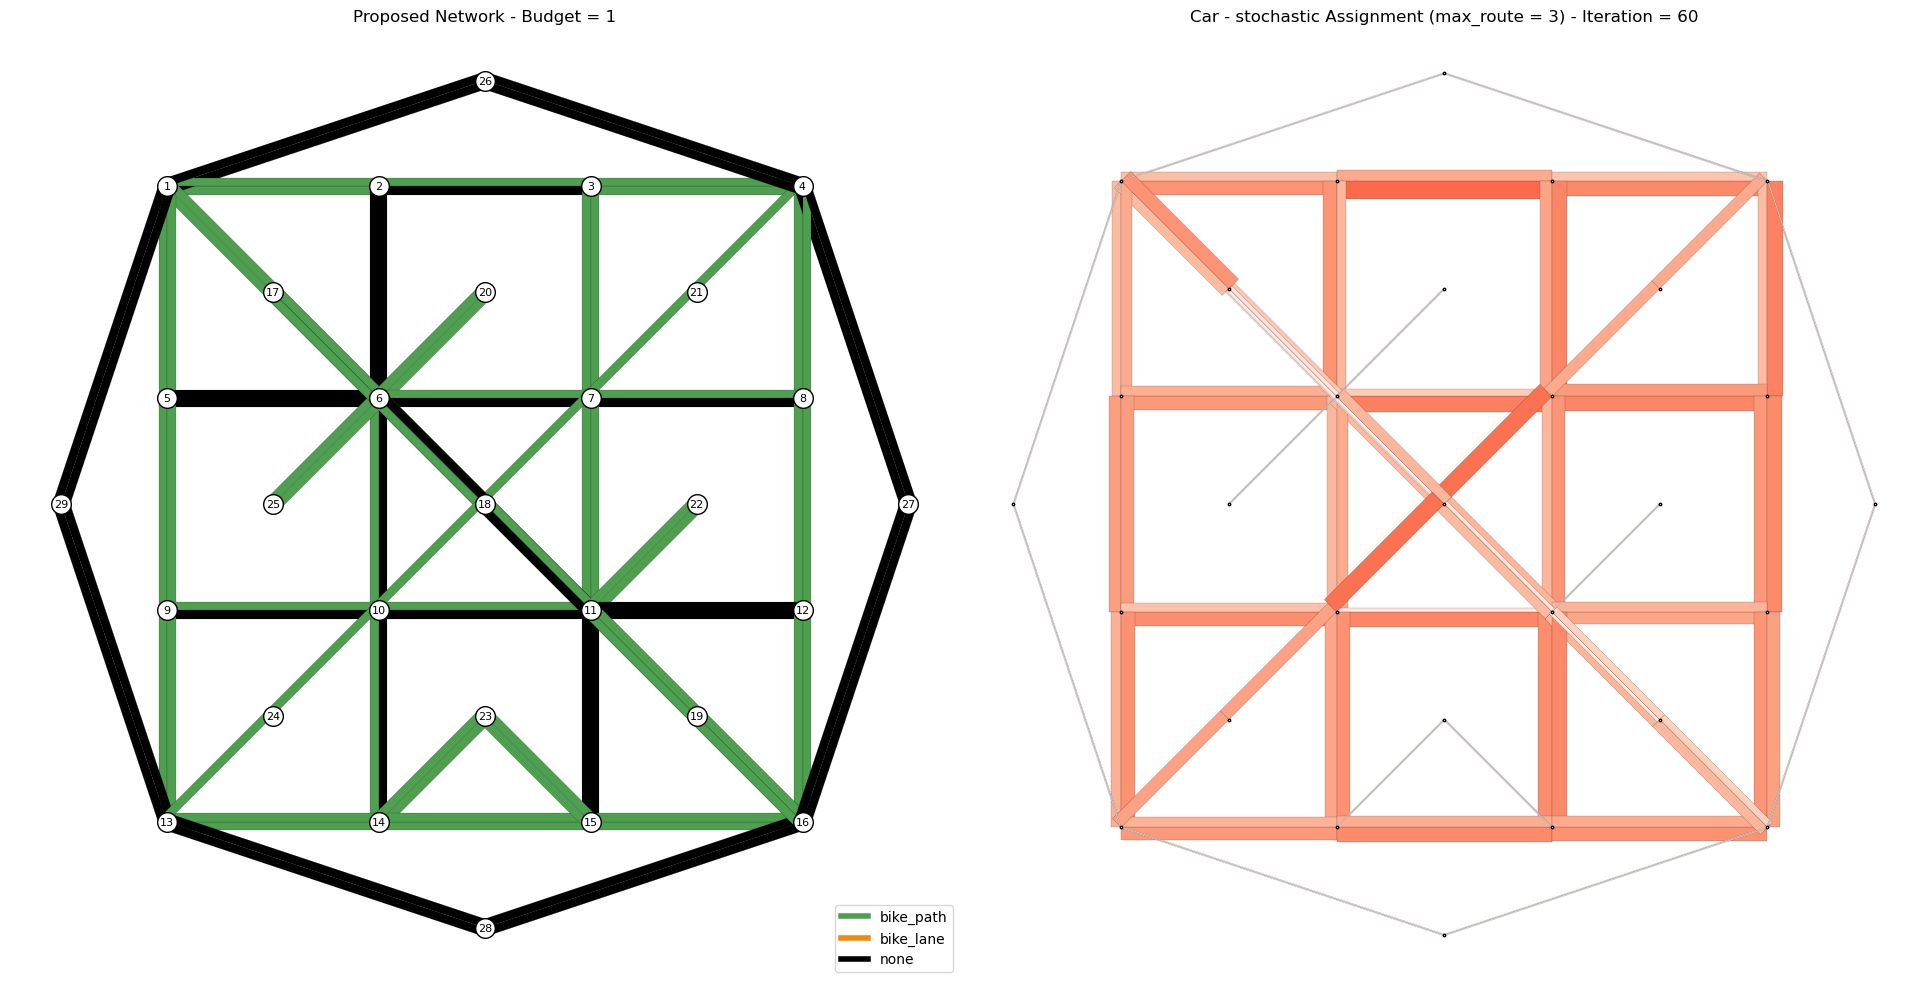

In [91]:

edge_df_proposed = edge_df_final.copy()
cbar_exists = False
# 1. Configuration initiale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

def update(budget):
    global cbar_exists
    # On vide les axes pour redessiner proprement
    axes[0].clear()
    axes[1].clear()
    
    # Calcul de l'itération dynamique selon votre formule
    iteration =  iteration_finale - budget
    
    # Premier graphique (Réseau proposé)
    plot_network(
        edge_df_proposed, node_df, 
        color_col_str='type_bike', base_width=1, width_scale=5, 
        node_size=200, legend=True, node_label=True, 
        title=f'Proposed Network - Budget = {budget}', 
        ax=axes[0]
    )

    # Second graphique (Assignation stochastique)
    # On utilise l'itération calculée au-dessus pour les noms de colonnes
    flow_col = f'flow_bike_iteration_{iteration}'
    for edge in edge_df_proposed.itertuples():
        if edge.iteration > iteration:
            if edge.lock_bike_infra == False:
                edge_df_proposed.loc[edge.Index, "type_bike"] = "bike_path"
        else:
            edge_df_proposed.loc[edge.Index, "type_bike"] = None

    plot_network(
        edge_df_proposed, node_df,
        width_col='flow_car_iteration_'+str(iteration),
        color_col_num='flow_car_iteration_'+str(iteration),
        cmap='Reds',
        title=f'Car - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (cars)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000,
        cbar_on=False
    )
    if cbar_exists:
            # On cherche la dernière colorbar ajoutée à la figure et on la retire
            # Les colorbars sont stockées dans fig.axes
            if len(fig.axes) > 3: # 2 axes originaux + 1 legende + la nouvelle cbar
                fig.axes[-1].remove()
    else:
        cbar_exists = True

ani = FuncAnimation(fig, update, frames=range(1, iteration_finale), interval=400)

ani.save("animation.gif", writer='pillow')